In [1]:
# imported dependencies
import pennylane as qml
import numpy as np
import helper_functions as helper

### Use Helper Functions to Create Rho & Generators
We are using the following generator set to detect bit-flip errors (created in [helper_functions.py](helper_functions.py)):  
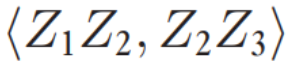

In [2]:
rho = helper.generate_density_matrix()
generators = helper.create_generators()

### Create Syndrome Measurement Function

We can detect physical errors by measuring the generators G1, ..., Gn-k. This is known as syndrome measurement!  

This circuit uses phase kick-back, therefore only requiring measurement of estimation wires to find errors in our target wire. 

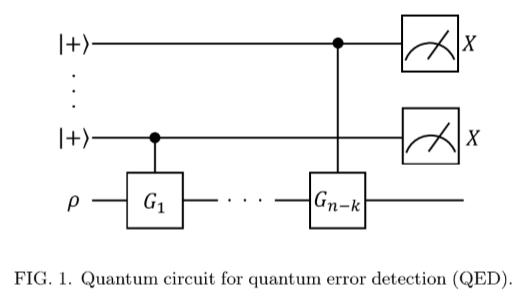

In [3]:
dev = qml.device("default.mixed", wires=5, shots=1)
@qml.qnode(dev)
def syndrome_measurement(density_matrix, generators, estimation_wires, target_wires):
    
    # Prepare target wires as our density matrix 
    qml.QubitDensityMatrix(density_matrix, wires=target_wires)
    
    for wire in estimation_wires:
        qml.Hadamard(wires=wire)
    
    # Introduce Bit Error onto any target wire
    # Here, we will choose to introduce it on the first target wire 
    qml.BitFlip(1, target_wires[0])

    L = len(estimation_wires)
    for i, generator in enumerate(generators):
        # Apply controlled generator operations
        qml.ControlledQubitUnitary(generator, control_wires=estimation_wires[L-1-i], wires=target_wires)
    
    measurements = []
    for wire in estimation_wires:
        measurements.append(qml.sample(qml.PauliX(wire)))
    return measurements

### Apply Syndrome Measurement

We have included a table of the outcome of our syndrome measurement, corresponding with a specific type of bit-flip error.  
This was referenced from [Quantum Computation and Quantum Information](http://mmrc.amss.cas.cn/tlb/201702/W020170224608149940643.pdf).  

The 2 left columns of the table are the expected results of syndrome measurement, given a bit-fip error specified in column 3.
 
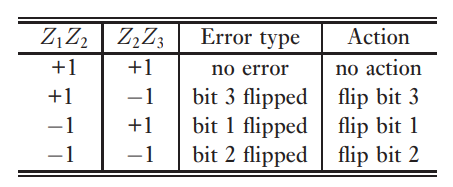

In [4]:
estimation_wires = [0,1]
target_wires = [2,3,4]

# We introduced a bit-flip error on the first wire, therefore we should see measurements [-1, +1].
# This corresponds to the error type of bit 1 flip on the table.
print("Syndrome measurements:")
print(syndrome_measurement(rho, generators, estimation_wires, target_wires))

print("\nA look into our circuit:")
print(qml.draw(syndrome_measurement)(rho, generators, estimation_wires, target_wires))

Syndrome measurements:
[[-1]
 [ 1]]

A look into our circuit:
0: ──H────────────────────────────────────────────╭●─────┤  Sample[X]
1: ──H─────────────────────────────────────╭●─────│──────┤  Sample[X]
2: ─╭QubitDensityMatrix(M0)──BitFlip(1.00)─├U(M1)─├U(M2)─┤           
3: ─├QubitDensityMatrix(M0)────────────────├U(M1)─├U(M2)─┤           
4: ─╰QubitDensityMatrix(M0)────────────────╰U(M1)─╰U(M2)─┤           
